# Adiabatic Non-Radial Pulsations in the standard solar model

Figure 11.7 from Chapter 11 of *Stellar Structure & Evolution* Pinsonneault & Ryden, Cambridge University Press.

Plot of scale heights and adiabatic non-radial pulsation frequencies for a present-day solar model
computed by author Marc Pinsonneault. Plots pressure and density scale heights in units of R<sub>sun</sub> on the left, and the Lamb frequency $S_\ell$ and Brunt-Vaisala frequency $N_{BV}$ along with the acoustic cutoff frequency $\omega_\textrm{ac}$ on the right.

The left panel of the figure is inspired by a figure from Christensen-Dalsgaard & Berthomieu, *Theory of Solar Oscillations* in *Solar interior and atmosphere*, University of Arizona Press, 1991, p. 401-478.

We do the calculation with numerical differentiation of the solar model data using the central difference method
implementation in numpy (`numpy.gradient`).

In [5]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Standard Plot Format

Setup the standard plotting format and make the plot.

In [6]:
plotFile = 'Fig11_7.png' 

# graphic aspect ratio = width/height

aspect = 2.5

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10.0
labelFontSize = 8.0
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)
    
# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

### Useful Physical parameters

Define useful constants here from IAU 2015 Resolution 3B, converted to cgs:
 * GMsun = solar mass parameter = $1.3271244\times 10^{26} {\rm cm}^3 {\rm s}^{-2}$
 * G = $6.67430\times 10^{-8} {\rm cm}^3 {\rm g}^{-1} {\rm s}^{-2}$
 * Rsun = $6.957\times 10^{10} \rm{cm}$

In [7]:
GMsun = 1.3271244e26 # cm^3/s^2
G = 6.67430e-8 # cgs
Rsun = 6.957e10 # cm

## Solar Model

We use a solar model calculation provided by author Marc Pinsonneault that contains a lot more information than
we need here. The file is slightly edited from the original to conform to the simple ASCII format we use elsewhere in these notebooks.

All data are in cgs units except as noted.  Data for masses, radii, etc. with large physical ranges are log10() 
quantities we convert to linear form for the calculations that follow.

In [8]:
dataFile = 'SolarModel_Pinsonneault.txt' # model data file from Marc Pinsonneault
data = pd.read_csv(dataFile,sep=r'\s+',comment='#')

m0 = 10.0**np.array(data['MASS'])
r0 = 10.0**np.array(data['RADIUS'])
rho0 = 10.0**np.array(data['DENSITY'])
P0 = 10.0**np.array(data['PRESSURE'])
gamma = np.array(data['GAM1'])

# axis limits

rMin = 0 # center
rMax = 1 # photosphere

wMin = 2.0e-4
wMax = 0.1 

# scale height limits

hMin = 0.0
hMax = 0.3 # Rsun

dR0 = 0.01*Rsun

### Adiabatic index ($\gamma$)

A common simplifying assumption is to perform the calculation with a constant value of the adiabatic index of $\gamma=5/3$ for a fully-ionized hydrogen plasma throughout.  However, we take a more rigorous approach and
use the $\gamma$ computed by the solar model (GAM1 column).  The computed $\gamma$ is about 5/3 through most
of the Sun's volume until the transition to the photosphere where it trends to lower values towards $\gamma$=4/3 
as the gas become partially neutral.

Using a constant $\gamma$ throughout would result in non-physical (non-imaginary) values of the Brunt-Vaisala 
frequency at the outermost radii.  

Comment out the constant value of `gamma` in the cell below to override the `gamma` list read from the data file
in the cell above to see how assuming a constant $\gamma=5/3$ this changes the calculation.

In [9]:
# gamma = 5.0/3.0

## Computations

### Lamb Frequency

The Lamb frequency $S_{\ell}$ is (book Eqn 11.51):
\begin{equation}
S_\ell^2 = k_h^2 c_s^2 = \frac{\ell (\ell+1)}{r^2} c_s^2 .
\end{equation}
We compute the Lamb frequency at four values of the angular degree $\ell$, $\ell$={1,4,16,64}

### Brunt-Vaisala Frequency

The Brunt-Vaisala frequency $N_{BV}$ is (book Eqn 11.53):
\begin{equation}
N_{BV}^2 = g_0 \left[ \frac{1}{\gamma} \frac{d\ln P_0}{dr} - \frac{d\ln \rho_0}{dr} \right]
\end{equation}
We compute the logarithmic gradients in pressure ($d\ln P_0/dr$) and density ($d\ln\rho_0/dr$) numerically using the interpolated model data with the central difference method implementation in numpy (`numpy.gradient`).

### Acoustic Cutoff Frequency

The acoustic cutoff frequency $\omega_\textrm{ac}$ is (book Eqn 11.59):
\begin{equation}
\omega_\textrm{ac}^2 = \frac{c_s^2}{4 h_\rho^2} \left( 1 - 2 \frac{dh_\rho}{dr} \right)
\end{equation}
where

We convert mass and radius from solar units into cgs (g and cm), and compute at each radius the following quantities:
$c_s$ is the adiabatic sound speed:
\begin{equation}
  c_s = \left(\gamma\frac{P_0}{\rho_0}\right)^{1/2}
\end{equation}
and 
$h_\rho$ is the density scale height:
\begin{equation}
  h_\rho (r) = \left| \frac{d\ln\rho_0}{dr} \right|^{-1}
\end{equation}

### other quantities

We also compute the gravitational acceleration, $g_0(r)$:
\begin{equation}
   g_0 = \frac{GM(r)}{r^2}
\end{equation}
and use that to compute the pressure scale height, $h_p(r)$:
\begin{equation}
  h_p = \frac{P_0}{g_0\rho_0}
\end{equation}

In [10]:
ell = [1,4,16,64] # angular degrees

# convert mass and radius into useful cgs units

m = m0 # *GMsun
r = r0 # *Rsun

# gravitational acceleration at each radius

g0 = G*m/(r*r)

# adiabatic sound speed at each radius

cs = np.sqrt(gamma*P0/rho0)

# the Lamb frequency at given ell

Sell = {}
slamb = cs/r
for l in ell:
    Sell[l] = math.sqrt(l*(l+1))*slamb

# the pressure scale height at each radius

hp = P0/(g0*rho0*Rsun)

# logarithmic pressure gradient

dlnP_dr = np.gradient(P0,r0)/P0

# logarithmic density gradient

dlnrho_dr = np.gradient(rho0,r0)/rho0

# the density scale height.  Give value of 0 if undefined

hrho = np.zeros(len(r))

pos = np.where(dlnrho_dr<0.0)
hrho[pos] = (1/np.absolute(dlnrho_dr[pos]))/Rsun

# the Brunt-Vaisala frequency, set to 0 where imaginary

Nbv2 = g0*((dlnP_dr/gamma) - dlnrho_dr) # /Rsun

Nbv = np.zeros(len(r))
pos = np.where(Nbv2>=0.0)
Nbv[pos] = np.sqrt(Nbv2[pos])

# the acoustic cutoff frequency, set to 0 where imaginary

dhrho_dr = Rsun*np.gradient(hrho,r0) # gradient of the density scale height 

ac2 = (0.25*cs**2/((hrho*Rsun)**2))*(1.0-2.0*dhrho_dr)

ac = np.zeros(len(r))
pos = np.where(ac2>=0.0)
ac[pos] = np.sqrt(ac2[pos])

## Figure 11.7

Two-panel, side-by-side plot.
 * Left: pressure and density scale heights ($h_P$ and $h_\rho$) as a function of radius
 * Right: frequency vs radius: Lamb frequencies for $\ell=1,4,16,64$, Brunt-Vaisala, and acoustic cutoff
 

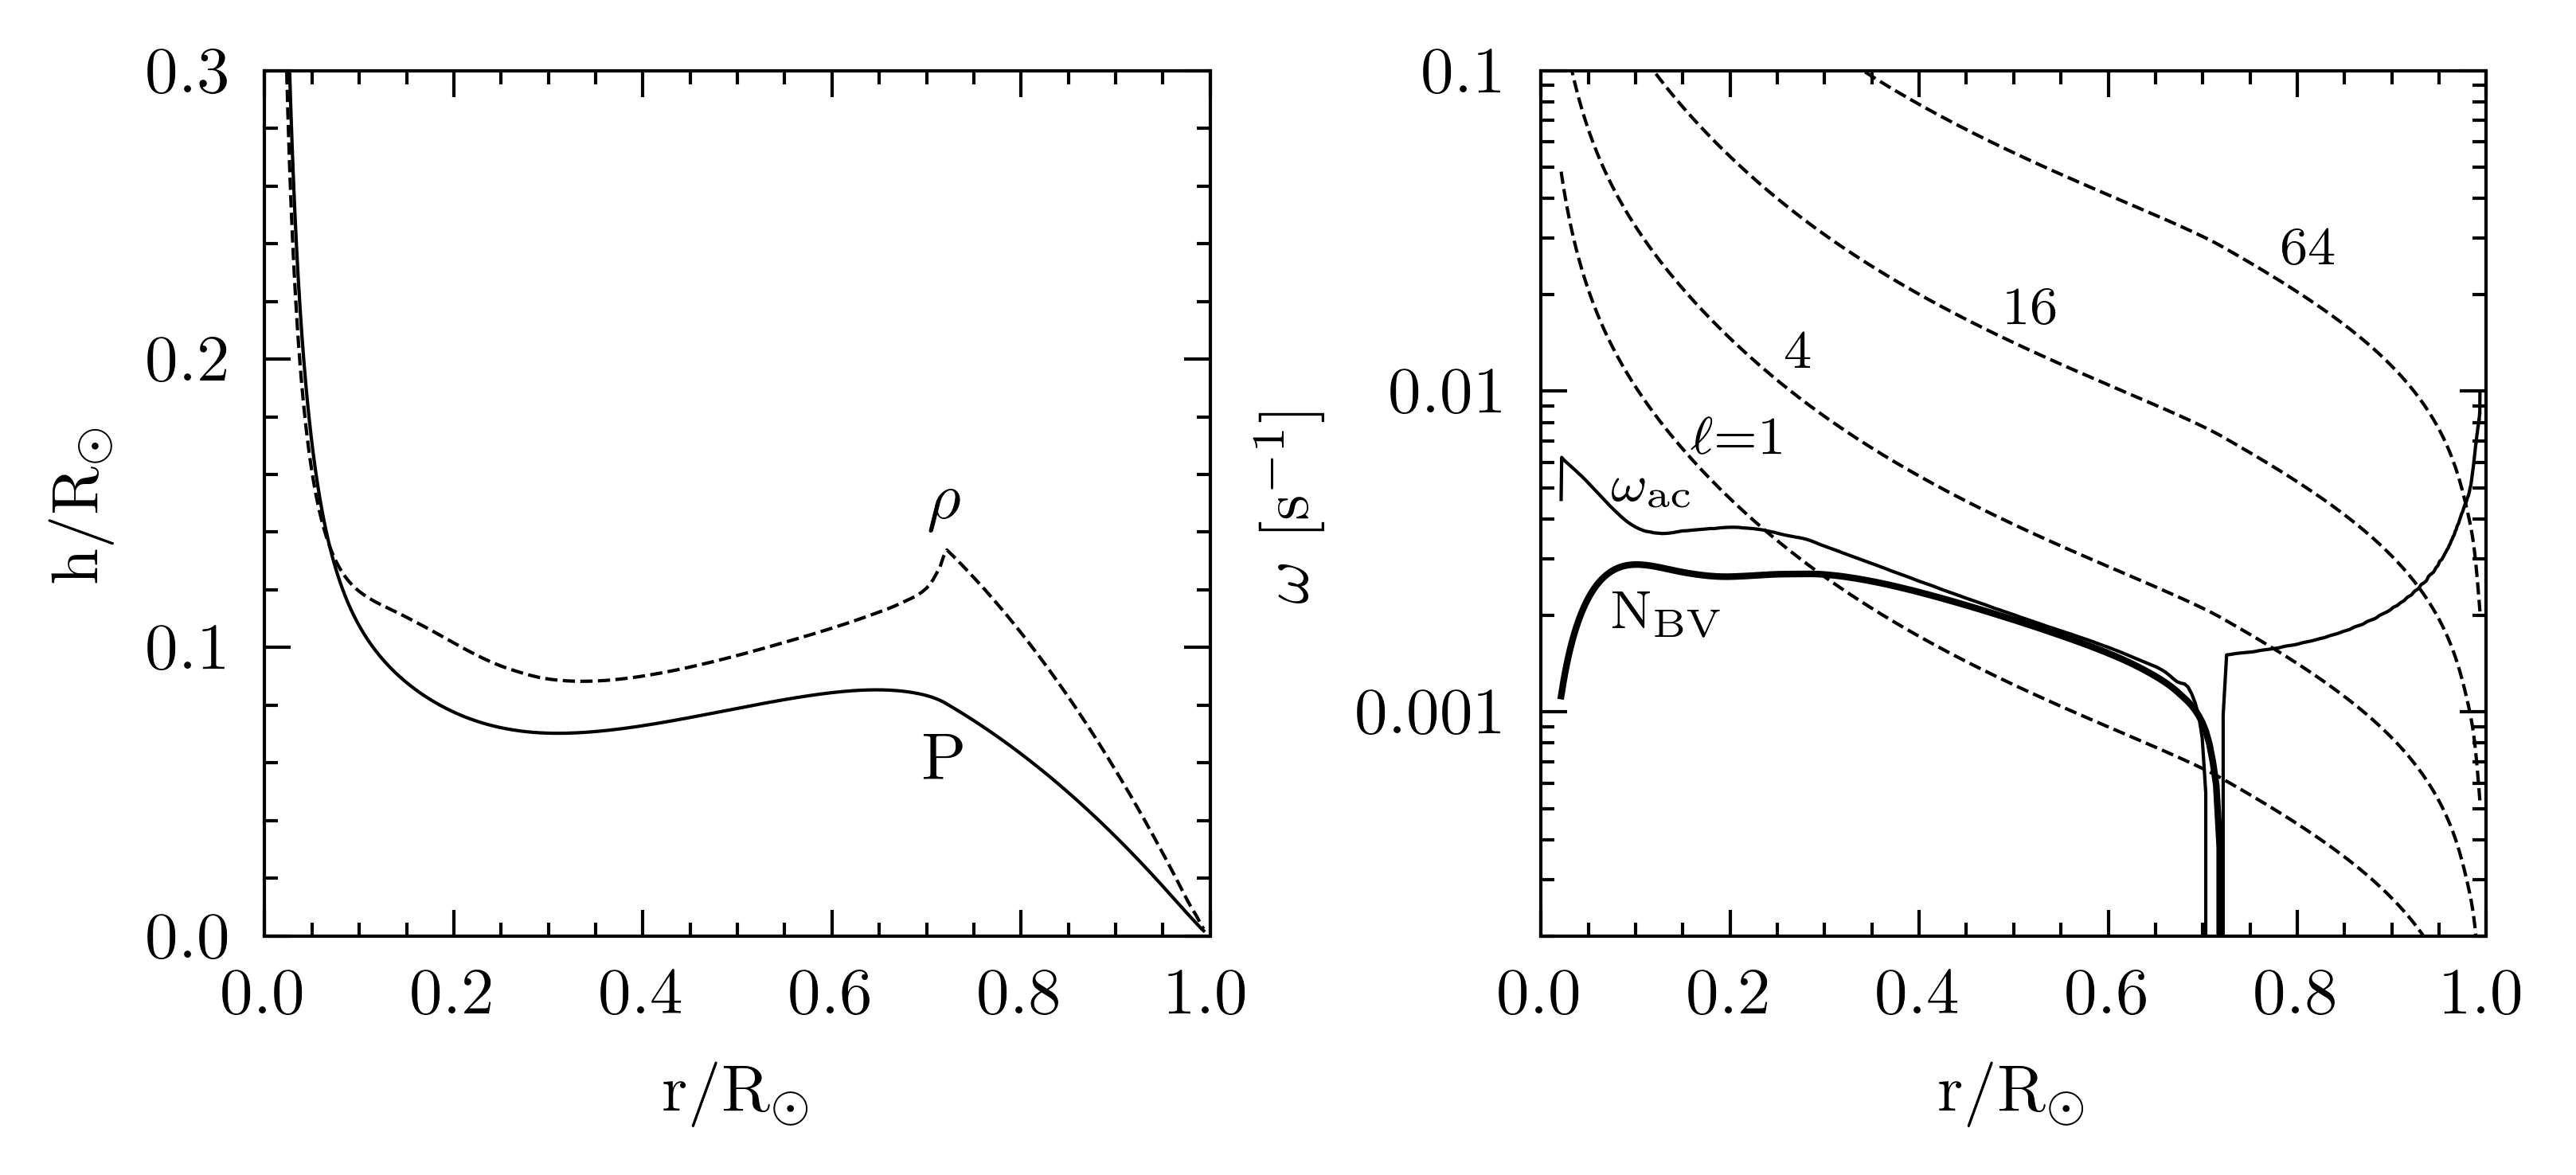

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(wInches,hInches),dpi=dpi)
    
fig.subplots_adjust(wspace=0.35, hspace=0)

# Panel 1 (left): pressure and density scale heights

ax1.tick_params('both',length=4,width=lwidth,which='major',direction='in',top='on',right='on')
ax1.tick_params('both',length=2,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax1.set_xlim(rMin,rMax)
ax1.set_xlabel(r'r/R$_{\odot}$',fontsize=axisFontSize)
ax1.xaxis.set_major_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(0.05))

ax1.set_ylim(hMin,hMax)
ax1.set_ylabel(r'h/R$_\odot$',fontsize=axisFontSize)
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.02))

ax1.plot(r0/Rsun,hp,'-',lw=0.5,color='black',zorder=10,label='Pressure')
ax1.text(0.72,0.06,'P',va='center',ha='center',fontsize=axisFontSize)
ax1.plot(r0/Rsun,hrho,'--',lw=0.5,color='black',zorder=10,label='Density')
ax1.text(0.72,0.15,r'$\rho$',va='center',ha='center',fontsize=axisFontSize)

# Panel 2 (right): pulsation frequency vs. radius

ax2.tick_params('both',length=4,width=lwidth,which='major',direction='in',top='on',right='on')
ax2.tick_params('both',length=2,width=lwidth,which='minor',direction='in',top='on',right='on')

ax2.set_xlim(rMin,rMax)
ax2.set_xlabel(r'r/R$_{\odot}$',fontsize=axisFontSize)
ax2.xaxis.set_major_locator(MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(MultipleLocator(0.05))

ax2.set_ylim(wMin,wMax)
ax2.set_yscale('log')
ax2.yaxis.set_ticks([0.001,0.01,0.1])
ax2.yaxis.set_ticklabels([r'0.001','0.01','0.1'])
ax2.set_ylabel(r'$\omega$ [s$^{-1}$]',fontsize=axisFontSize)

# Brunt-Vaisala frequency

ax2.plot(r0/Rsun,Nbv,'-',lw=1,color='black',zorder=10)
ax2.text(0.075,0.002,r'N$_{\rm BV}$',va='center',ha='left',fontsize=labelFontSize)

# Lamb frequencies for different ell values

for i, l in enumerate(ell):
    ax2.plot(r0/Rsun,Sell[l],'--',lw=0.5,color='black',zorder=10)
    if l==1:
        idx = np.where(Sell[l]<=0.007)[0][0]
        ax2.text((r0[idx]+1.5*dR0)/Rsun,0.007,r'$\ell$=1',va='center',ha='left',fontsize=labelFontSize)
    else:
        slab = 0.007 + math.sqrt(l)*0.002
        idx = np.where(Sell[l]<=slab)[0][0]
        ax2.text((r0[idx]+dR0)/Rsun,slab,rf'{l}',va='bottom',ha='left',fontsize=labelFontSize)
    
# acoustic cutoff frequency

ax2.plot(r0/Rsun,ac,'-',lw=0.5,color='black',zorder=10)
ax2.text(0.075,0.005,r'$\omega_{\rm ac}$',va='center',ha='left',fontsize=labelFontSize)

# Make the plot

plt.plot()
plt.savefig(plotFile,bbox_inches='tight',facecolor='white')